In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, random
from tabulate import tabulate
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from keras import applications
import gc
import tensorflow as tf
from skimage import data, io, filters
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
gc.collect()

9870

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path  = '/content/drive/My Drive/Colab Notebooks/Garbage classification'

classes = os.listdir(base_path)
print(classes)

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


**Transformation to tensor**

In [ ]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(base_path, transform = transformations)


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

**Visualising initial data**

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

**We have equal poplulation of all classes of data**

Text(0, 0.5, 'population')

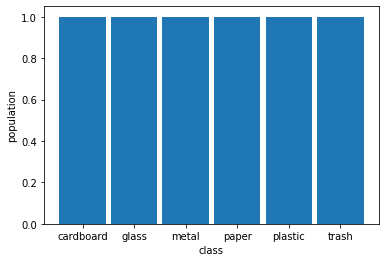

In [ ]:
plt.hist(dataset.classes, bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Creating Modelbase**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

**Porting to GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


**Training model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.2048611044883728, 'val_loss': 1.7971141338348389}

In [ ]:
num_epochs =8
opt_func = torch.optim.Adam
lr = 5.5e-5


In [ ]:
history_adam = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.0454, val_loss: 1.0885, val_acc: 0.9688
Epoch 2: train_loss: 1.0452, val_loss: 1.0882, val_acc: 0.9549
Epoch 3: train_loss: 1.0462, val_loss: 1.0855, val_acc: 0.9601
Epoch 4: train_loss: 1.0448, val_loss: 1.0851, val_acc: 0.9670
Epoch 5: train_loss: 1.0451, val_loss: 1.0856, val_acc: 0.9601
Epoch 6: train_loss: 1.0454, val_loss: 1.0850, val_acc: 0.9549
Epoch 7: train_loss: 1.0459, val_loss: 1.0830, val_acc: 0.9549
Epoch 8: train_loss: 1.0448, val_loss: 1.0861, val_acc: 0.9549


In [ ]:
opt_func = torch.optim.Adamax

history_adamax = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.0453, val_loss: 1.0820, val_acc: 0.9618
Epoch 2: train_loss: 1.0448, val_loss: 1.0974, val_acc: 0.9497
Epoch 3: train_loss: 1.0451, val_loss: 1.0975, val_acc: 0.9427
Epoch 4: train_loss: 1.0447, val_loss: 1.0918, val_acc: 0.9514
Epoch 5: train_loss: 1.0449, val_loss: 1.0882, val_acc: 0.9670
Epoch 6: train_loss: 1.0448, val_loss: 1.0960, val_acc: 0.9444
Epoch 7: train_loss: 1.0450, val_loss: 1.0936, val_acc: 0.9479


**Trying cross validation**

**Plots for accuracy, loss and epochs**

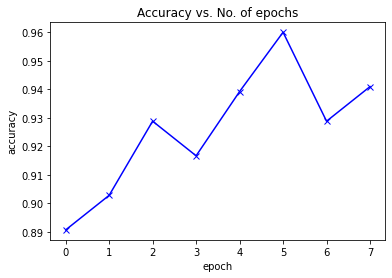

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history_adam)

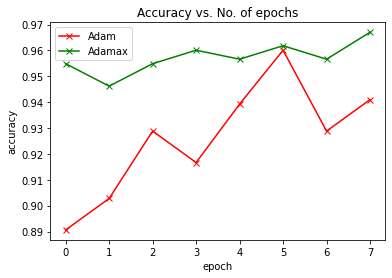

In [ ]:
def plot_comparisons(history1, history2):
    accuracies1 = [x['val_acc'] for x in history_adam]
    accuracies2 = [x['val_acc'] for x in history_adamax]
    plt.plot(accuracies1, '-rx', label="Adam")
    plt.plot(accuracies2, '-gx', label="Adamax")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs');

plot_comparisons(history_adam, history_adamax)

Adam Losses


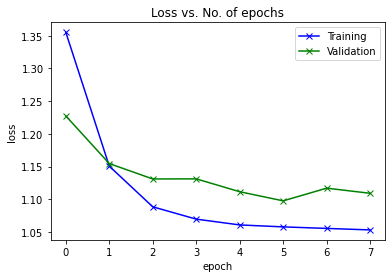

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

print("Adam Losses")
plot_losses(history_adam)

Adamax Losses


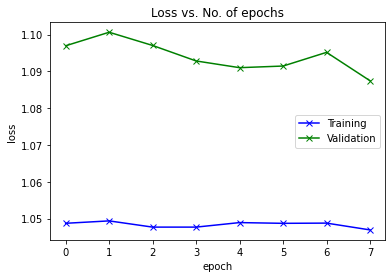

In [ ]:
print("Adamax Losses")
plot_losses(history_adamax)

**Visualizing final Predictions**

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


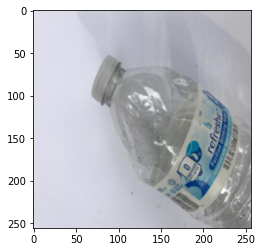

In [ ]:
img, label = test_ds[42]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


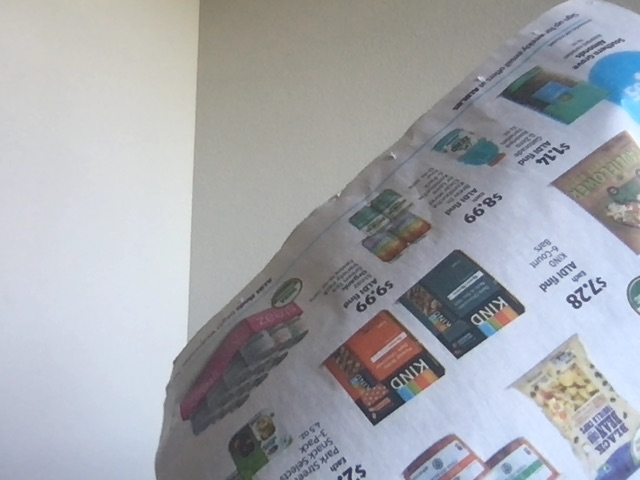

In [136]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [137]:
# source -- https://medium.com/jun-devpblog/pytorch-4-custom-dataset-class-convert-image-to-tensor-and-vice-versa-57afd90a4313

import torchvision
from PIL import Image
import numpy as np

#### Stage 1: Load image and save it as torch.Tensor
# load the image
image = Image.open('photo.jpg')
# print(image)
# show the image
# image.show()

# transform Image into the numpy array
image_2_npArray = np.asarray(image)
# print(np.shape(image_2_npArray))
# print('the shape of loaded image transformed into numpy array: {}'.format(np.shape(image_2_npArray)))
# print('transformed image: {}'.format(image_2_npArray))

# transform the numpy array into the tensor
image_2_npArray_2_tensor = torchvision.transforms.ToTensor()(image_2_npArray)
# print('the shape of numpy array transformed into tensor: {}'.format(np.shape(image_2_npArray_2_tensor)))
# print('transformed numpy array: {}'.format(image_2_npArray_2_tensor))

type(image_2_npArray_2_tensor)

torch.Tensor

Prediction: paper


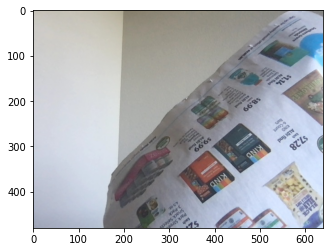

In [138]:
plt.imshow(image_2_npArray_2_tensor.permute(1, 2, 0))
print('Prediction:', predict_image(image_2_npArray_2_tensor, model))